In [22]:
import numpy as np
import matplotlib.pyplot as plt

In [23]:
##############################################################################
# simulate the states and observations
##############################################################################
def simulate(k=200, D=np.array([1, 0, 0, 0, 0, 0]), delta=0, warmup=False):
    """
    Simulates a sequence of states and observations for given HMM parameters.

    Args:
    - k: Length of the sequence (default 200)
    - D: Initial state probabilities (default [1, 0, 0, 0, 0, 0])
    - delta: Policy modifier (default 0)
    - warmup: If True, simulate 50 warm-up steps and return the result from step 51 (default False)

    Returns:
    - s_onehot: One-hot encoded state sequence
    - o_onehot: One-hot encoded observation sequence
    """

    B = np.array([
        [0.1, 0.9, 0, 0, 0, 0],
        [0.2, 0, 0.1 + delta, 0, 0, 0.7 - delta],
        [0, 0.5, 0, 0.5, 0, 0],
        [0, 0, 0.5, 0.5, 0, 0],
        [0, 0, 0.1, 0, 0.4, 0.5],
        [0, 0.2, 0, 0, 0.7, 0.1]
    ])

    A = np.array([
        [0.25, 0.25, 0.25, 0.25],
        [0.35, 0.35, 0.15, 0.15],
        [0.4, 0.4, 0.1, 0.1],
        [0.4, 0.4, 0.1, 0.1],
        [0.05, 0.05, 0.2, 0.7],
        [0.1, 0.05, 0.35, 0.5]
    ])

    total_steps = k + 50 if warmup else k

    s = np.zeros(total_steps, dtype=int)
    o = np.zeros(total_steps, dtype=int)

    # Initial state and observation
    s[0] = np.random.choice(6, p=D)
    o[0] = np.random.choice(4, p=A[s[0], :])

    # Simulate the sequence
    for t in range(1, total_steps):
        s[t] = np.random.choice(6, p=B[s[t - 1], :])
        o[t] = np.random.choice(4, p=A[s[t], :])

    # Apply warm-up logic
    if warmup:
        s = s[50:]
        o = o[50:]

    s_onehot = np.eye(6)[s]
    o_onehot = np.eye(4)[o]

    return s_onehot, o_onehot

def viterbi_decode(o, A, B):
    """Decodes the most likely state sequence given an observation sequence and HMM parameters.

    Args:
    - o: Observation sequence
    - A: emission matrix
    - B: Transition matrix

    """
    n_obs = len(o)
    n_states = B.shape[0]
    dp = np.zeros((n_obs, n_states))
    prev = np.zeros((n_obs, n_states), dtype=int)

    dp[0] = np.log(A[:, o[0]])
    for t in range(1, n_obs):
        for i in range(n_states):
            temp = dp[t - 1] + np.log(B[:, i]) + np.log(A[i, o[t]])
            dp[t, i] = np.max(temp)
            prev[t, i] = np.argmax(temp)
    path = np.zeros(n_obs, dtype=int)
    path[-1] = np.argmax(dp[-1])
    for t in range(n_obs - 2, -1, -1):
        path[t] = prev[t + 1, path[t + 1]]

    return path + 1

# A

In [3]:
# Generate 101 observations since we need observations[100] to calculate belief[99]
k = 101
D = np.array([1, 0, 0, 0, 0, 0])
delta = 0.1
warmup = True
states, observations = simulate(k, D, delta,warmup)

In [4]:
B = np.array([
    [0.1, 0.9, 0, 0, 0, 0],
    [0.2, 0, 0.1 + delta, 0, 0, 0.7 - delta],
    [0, 0.5, 0, 0.5, 0, 0],
    [0, 0, 0.5, 0.5, 0, 0],
    [0, 0, 0.1, 0, 0.4, 0.5],
    [0, 0.2, 0, 0, 0.7, 0.1]
])
A = np.array([
    [0.25, 0.25, 0.25, 0.25],
    [0.35, 0.35, 0.15, 0.15],
    [0.4, 0.4, 0.1, 0.1],
    [0.4, 0.4, 0.1, 0.1],
    [0.05, 0.05, 0.2, 0.7],
    [0.1, 0.05, 0.35, 0.5]
])

In [24]:
def update_beliefs(observations, D, B, A):
    """
    observations: Array of simulated observations
    D: Initial probability matrix
    A: Observation matrix
    B: Transition matrix
    v: Average membrane potential
    """
    k = len(observations)
    beliefs = np.zeros((k, len(D)))
    v = np.zeros((k, len(D)))
    beliefs[0] = D
    for t in range(1, k):
        forward = np.dot(B, beliefs[t-1] + 1e-8)
        backward = np.dot(B.T, beliefs[t+1] + 1e-8) if t < k - 1 else np.ones(len(D))
        o_t = observations[t]
        observation_likelihood = np.dot(A, o_t)
        epsilon = 0.5 * (np.log(forward + 1e-8) + np.log(backward + 1e-8)) + np.log(observation_likelihood + 1e-8) - np.log(beliefs[t] + 1e-8)
        v[t] = v[t] + epsilon
        beliefs[t] = np.exp(v[t] - np.max(v[t]))
        beliefs[t] /= beliefs[t].sum()

    beliefs = beliefs[0:k-1]
    return beliefs, v

In [6]:
'''
def update_beliefs_cont(beliefs_1, v_1, observations, B, A):
    k = 9
    beliefs = np.zeros((k, 6))
    v = np.zeros((k, 6))
    beliefs[0] = beliefs_1
    v[0] = v_1
    for t in range(1, k):
        forward = np.dot(B, beliefs[t-1] + 1e-8)
        backward = np.dot(B.T, beliefs[t+1] + 1e-8)
        o_t = observations[t].T
        observation_likelihood = np.dot(A, o_t)
        epsilon = 0.5 * (np.log(forward + 1e-8) + np.log(backward + 1e-8)) + np.log(observation_likelihood + 1e-8) - np.log(beliefs[t] + 1e-8)
        v[t] = v[t] + epsilon
        beliefs[t] = np.exp(v[t] - np.max(v[t]))
        beliefs[t] /= beliefs[t].sum()

    beliefs = beliefs[0:k-1]
    return beliefs, v
'''

'\ndef update_beliefs_cont(beliefs_1, v_1, observations, B, A):\n    k = 9\n    beliefs = np.zeros((k, 6))\n    v = np.zeros((k, 6))\n    beliefs[0] = beliefs_1\n    v[0] = v_1\n    for t in range(1, k):\n        forward = np.dot(B, beliefs[t-1] + 1e-8)\n        backward = np.dot(B.T, beliefs[t+1] + 1e-8)\n        o_t = observations[t].T\n        observation_likelihood = np.dot(A, o_t)\n        epsilon = 0.5 * (np.log(forward + 1e-8) + np.log(backward + 1e-8)) + np.log(observation_likelihood + 1e-8) - np.log(beliefs[t] + 1e-8)\n        v[t] = v[t] + epsilon\n        beliefs[t] = np.exp(v[t] - np.max(v[t]))\n        beliefs[t] /= beliefs[t].sum()\n\n    beliefs = beliefs[0:k-1]\n    return beliefs, v\n'

In [7]:
beliefs, v = update_beliefs(observations, D, B, A)

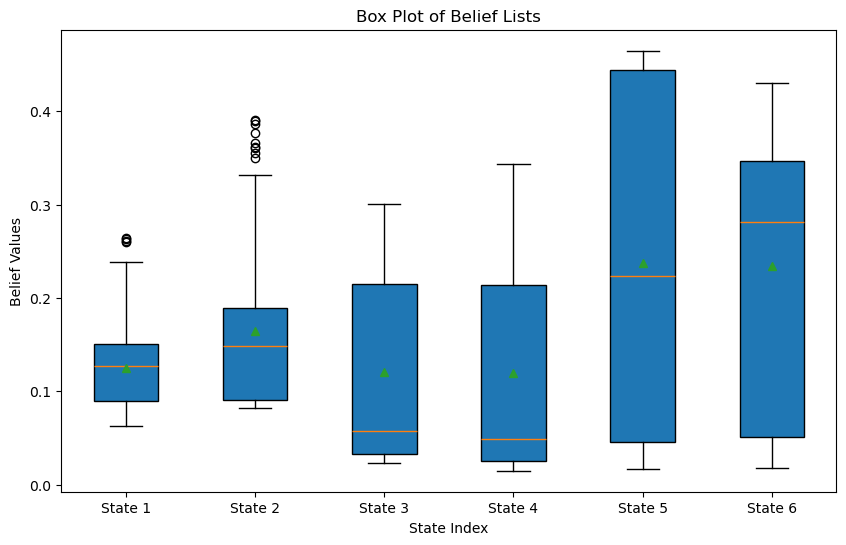

In [8]:
plt.figure(figsize=(10, 6))
plt.boxplot(beliefs[3:], vert=True, patch_artist=True, showmeans=True)

plt.xlabel("State Index")
plt.ylabel("Belief Values")
plt.title("Box Plot of Belief Lists")
plt.xticks(ticks=range(1, beliefs.shape[1] + 1), labels=[f"State {i}" for i in range(1, beliefs.shape[1] + 1)])

plt.show()

# B

In [9]:
k = 101
D = np.array([1, 0, 0, 0, 0, 0])
delta = 0.4
warmup = True
states, observations = simulate(k, D, delta,warmup)

In [10]:
beliefs, v = update_beliefs(observations, D, B, A)

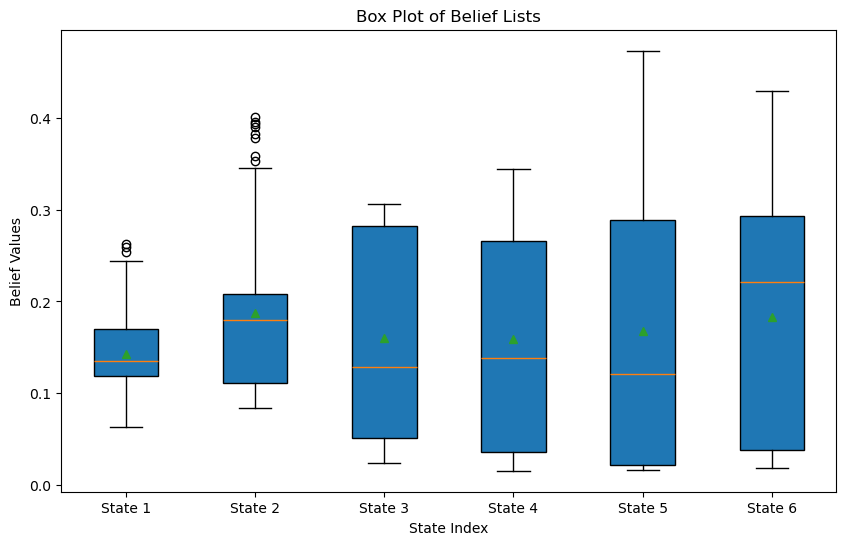

In [11]:
plt.figure(figsize=(10, 6))
plt.boxplot(beliefs[3:], vert=True, patch_artist=True, showmeans=True)

plt.xlabel("State Index")
plt.ylabel("Belief Values")
plt.title("Box Plot of Belief Lists")
plt.xticks(ticks=range(1, beliefs.shape[1] + 1), labels=[f"State {i}" for i in range(1, beliefs.shape[1] + 1)])

plt.show()

If when choose delta = 0.4, which leads to less risky states. The beliefs of risky state 5 and state 6 is less.

# C

policy 1: delta = 0.1

In [12]:
k = 101
D = np.array([1, 0, 0, 0, 0, 0])
delta = 0.1
warmup = True
states, observations = simulate(k, D, delta,warmup)

In [13]:
# Using KL Divergence since c_t has 0s
theta = 1e-7
c_t = np.array([0.5 - theta/2, 0.5 - theta/2, theta/2, theta/2])

In [14]:
beliefs, v = update_beliefs(observations, D, B, A)

In [15]:
s_policy1 = beliefs[99]
s_policy1

array([0.1869902 , 0.22901334, 0.29336523, 0.23482848, 0.02607078,
       0.02973196])

In [16]:
o_policy1 = np.dot(A.T,s_policy1)

In [17]:
np.dot(o_policy1, np.log(o_policy1) - np.log(c_t))

4.4787910560878705

policy 2: delta = 0.4

In [18]:
k = 101
D = np.array([1, 0, 0, 0, 0, 0])
delta = 0.4
warmup = True
states, observations = simulate(k, D, delta,warmup)

In [19]:
beliefs, v = update_beliefs(observations, D, B, A)

In [20]:
s_policy2 = beliefs[99]
s_policy2

array([0.13468407, 0.18844364, 0.29941956, 0.34208642, 0.01671982,
       0.01864648])

In [21]:
o_policy2 = np.dot(A.T,s_policy2)
o_policy2

array([0.35892933, 0.357997  , 0.13595839, 0.14711528])

In [22]:
np.dot(o_policy2, np.log(o_policy2) - np.log(c_t))

3.9669962120036844

# D

policy 1: delta = 0.1

In [23]:
k = 101
D = np.array([1, 0, 0, 0, 0, 0])
delta = 0.1
warmup = True
states, observations = simulate(k, D, delta,warmup)

In [24]:
beliefs, v = update_beliefs(observations, D, B, A)

In [25]:
matrix1 = -np.diag(np.dot(A, np.log(A.T)))

In [26]:
np.dot(matrix1, beliefs[99])

1.226051404403989

policy 2: delta = 0.4

In [27]:
k = 101
D = np.array([1, 0, 0, 0, 0, 0])
delta = 0.4
warmup = True
states, observations = simulate(k, D, delta, warmup)

In [28]:
beliefs, v = update_beliefs(observations, D, B, A)

In [29]:
matrix2 = -np.diag(np.dot(A, np.log(A.T)))

In [30]:
np.dot(matrix2, beliefs[99])

1.0396823538723958

# E

# If loop just one policy

In [31]:
mu = [0, 0.1, -0.1, 0.2]

In [32]:
policy_1 = [mu[3], mu[0], mu[1], mu[2]]
policy_2 = [mu[0], mu[3], mu[2], mu[2]]
policy_3 = [mu[0], mu[0], mu[1], mu[2]]

In [33]:
# Initial beliefs
k = 101
D = np.array([1, 0, 0, 0, 0, 0])
delta = 0.1
warmup = True
states, observations = simulate(k, D, delta, warmup)

In [34]:
states_list = []
observations_list = []
l = 1
# Loop for 10 time steps
for t in range(1, 12):  # t from 1 to 10
    current_policy = policy_1[(t - 1) % len(policy_1)]
    delta = current_policy
    states_cont, observations_cont = simulate(l, D, delta, warmup)
    states_list.append(states_cont)
    observations_list.append(observations_cont)

In [35]:
observations_list = np.vstack(observations_list)
beliefs, v = update_beliefs(observations, D, B, A)
Transition_matrix = []
Transition_matrix.append(B)
for t in range(1, 11):  # t from 1 to 10
    current_policy = policy_1[(t - 1) % len(policy_1)]
    delta = current_policy
    Transition_matrix.append(B)

In [36]:
k = len(observations_list)
beliefs_updated = np.zeros((k, len(D)))
beliefs_updated[0] = beliefs[99]
v_updated = np.zeros((k, len(D)))
v_updated[0] = v[99]

In [37]:
for t in range(1, 10):  # t from 0 to 9
    forward = np.dot(Transition_matrix[t-1], beliefs_updated[t-1] + 1e-8)
    backward = np.dot(Transition_matrix[t+1].T, beliefs_updated[t+1] + 1e-8)
    o_t = observations_list[t]
    observation_likelihood = np.dot(A, o_t)
    epsilon = 0.5 * (np.log(forward + 1e-8) + np.log(backward + 1e-8)) + np.log(observation_likelihood + 1e-8) - np.log(beliefs_updated[t] + 1e-8)
    v[t] = v[t] + epsilon
    beliefs_updated[t] = np.exp(v[t] - np.max(v[t]))
    beliefs_updated[t] /= beliefs_updated[t].sum()

In [38]:
policy1_belief = beliefs_updated[9]
policy1_belief

array([0.04063832, 0.02178713, 0.00639196, 0.00368243, 0.54461567,
       0.38288448])

policy 2

In [39]:
states_list = []
observations_list = []
l = 1
# Loop for 10 time steps
for t in range(1, 12):  # t from 1 to 10
    current_policy = policy_2[(t - 1) % len(policy_2)]
    delta = current_policy
    states_cont, observations_cont = simulate(l, D, delta, warmup)
    states_list.append(states_cont)
    observations_list.append(observations_cont)

In [40]:
observations_list = np.vstack(observations_list)
Transition_matrix = []
Transition_matrix.append(B)
for t in range(1, 11):  # t from 1 to 10
    current_policy = policy_2[(t - 1) % len(policy_2)]
    delta = current_policy
    Transition_matrix.append(B)

In [41]:
k = len(observations_list)
beliefs_updated = np.zeros((k, len(D)))
beliefs_updated[0] = beliefs[99]
v_updated = np.zeros((k, len(D)))
v_updated[0] = v[99]

In [42]:
for t in range(1, 10):  # t from 0 to 9
    forward = np.dot(Transition_matrix[t-1], beliefs_updated[t-1] + 1e-8)
    backward = np.dot(Transition_matrix[t+1].T, beliefs_updated[t+1] + 1e-8)
    o_t = observations_list[t]
    observation_likelihood = np.dot(A, o_t)
    epsilon = 0.5 * (np.log(forward + 1e-8) + np.log(backward + 1e-8)) + np.log(observation_likelihood + 1e-8) - np.log(beliefs_updated[t] + 1e-8)
    v[t] = v[t] + epsilon
    beliefs_updated[t] = np.exp(v[t] - np.max(v[t]))
    beliefs_updated[t] /= beliefs_updated[t].sum()

In [43]:
policy2_belief = beliefs_updated[9]
policy2_belief

array([0.08646222, 0.06758635, 0.02047283, 0.00712054, 0.30187938,
       0.51647867])

policy 3

In [44]:
states_list = []
observations_list = []
l = 1
# Loop for 10 time steps
for t in range(1, 12):  # t from 1 to 10
    current_policy = policy_3[(t - 1) % len(policy_3)]
    delta = current_policy
    states_cont, observations_cont = simulate(l, D, delta, warmup)
    states_list.append(states_cont)
    observations_list.append(observations_cont)

In [45]:
observations_list = np.vstack(observations_list)
Transition_matrix = []
Transition_matrix.append(B)
for t in range(1, 11):  # t from 1 to 10
    current_policy = policy_3[(t - 1) % len(policy_3)]
    delta = current_policy
    Transition_matrix.append(B)

In [46]:
k = len(observations_list)
beliefs_updated = np.zeros((k, len(D)))
beliefs_updated[0] = beliefs[99]
v_updated = np.zeros((k, len(D)))
v_updated[0] = v[99]

In [47]:
for t in range(1, 10):  # t from 0 to 9
    forward = np.dot(Transition_matrix[t-1], beliefs_updated[t-1] + 1e-8)
    backward = np.dot(Transition_matrix[t+1].T, beliefs_updated[t+1] + 1e-8)
    o_t = observations_list[t]
    observation_likelihood = np.dot(A, o_t)
    epsilon = 0.5 * (np.log(forward + 1e-8) + np.log(backward + 1e-8)) + np.log(observation_likelihood + 1e-8) - np.log(beliefs_updated[t] + 1e-8)
    v[t] = v[t] + epsilon
    beliefs_updated[t] = np.exp(v[t] - np.max(v[t]))
    beliefs_updated[t] /= beliefs_updated[t].sum()

In [48]:
policy3_belief = beliefs_updated[9]
policy3_belief

array([0.09133439, 0.14554346, 0.03140466, 0.00567981, 0.14031092,
       0.58572676])

calculate the risk estimations of these three policies

In [49]:
c1 = np.array([0.25, 0.25, 0.25, 0.25])
c2 = np.array([0.45, 0.45, 0.05, 0.05])

In [50]:
o_policy1 = np.dot(A.T, policy1_belief)
o_policy2 = np.dot(A.T, policy2_belief)
o_policy3 = np.dot(A.T, policy3_belief)

For c1:

In [51]:
risk_policy1 = np.dot(o_policy1, np.log(o_policy1) - np.log(c1))
risk_policy2 = np.dot(o_policy2, np.log(o_policy2) - np.log(c1))
risk_policy3 = np.dot(o_policy3, np.log(o_policy3) - np.log(c1))
print(risk_policy1)
print(risk_policy2)
print(risk_policy3)

0.3282771778512513
0.20135835394028367
0.120039367599445


policy3 is better since it has lower values for the risk term

For c2:

In [52]:
risk_policy1 = np.dot(o_policy1, np.log(o_policy1) - np.log(c2))
risk_policy2 = np.dot(o_policy2, np.log(o_policy2) - np.log(c2))
risk_policy3 = np.dot(o_policy3, np.log(o_policy3) - np.log(c2))
print(risk_policy1)
print(risk_policy2)
print(risk_policy3)

1.5959941323068185
1.3268004439777648
1.1162202590422272


policy3 is better since it has lower values for the risk term

# If we could choose policy every 4 steps

In [2]:
from itertools import product

In [40]:
A = np.array([
    [0.25, 0.25, 0.25, 0.25],
    [0.35, 0.35, 0.15, 0.15],
    [0.4, 0.4, 0.1, 0.1],
    [0.4, 0.4, 0.1, 0.1],
    [0.05, 0.05, 0.2, 0.7],
    [0.1, 0.05, 0.35, 0.5]
])
B = np.array([
    [0.1, 0.9, 0, 0, 0, 0],
    [0.2, 0, 0.1 + delta, 0, 0, 0.7 - delta],
    [0, 0.5, 0, 0.5, 0, 0],
    [0, 0, 0.5, 0.5, 0, 0],
    [0, 0, 0.1, 0, 0.4, 0.5],
    [0, 0.2, 0, 0, 0.7, 0.1]
])
c1 = np.array([0.25, 0.25, 0.25, 0.25])
c2 = np.array([0.45, 0.45, 0.05, 0.05])

In [4]:
# Define the policies
mu = [0, 0.1, -0.1, 0.2]
policy_1 = [mu[3], mu[0], mu[1], mu[2]]
policy_2 = [mu[0], mu[3], mu[2], mu[2]]
policy_3 = [mu[0], mu[0], mu[1], mu[2]]

# List of policies
policies = [policy_1, policy_2, policy_3]

# Number of steps
t_steps = 3

# Generate all combinations of policies for t_steps
policy_combinations = list(product(policies, repeat=t_steps))

# Concatenate the actions for each combination
all_combinations = [sum(combination, []) for combination in policy_combinations]

In [18]:
all_combinations

[[0.2, 0, 0.1, -0.1, 0.2, 0, 0.1, -0.1, 0.2, 0, 0.1, -0.1],
 [0.2, 0, 0.1, -0.1, 0.2, 0, 0.1, -0.1, 0, 0.2, -0.1, -0.1],
 [0.2, 0, 0.1, -0.1, 0.2, 0, 0.1, -0.1, 0, 0, 0.1, -0.1],
 [0.2, 0, 0.1, -0.1, 0, 0.2, -0.1, -0.1, 0.2, 0, 0.1, -0.1],
 [0.2, 0, 0.1, -0.1, 0, 0.2, -0.1, -0.1, 0, 0.2, -0.1, -0.1],
 [0.2, 0, 0.1, -0.1, 0, 0.2, -0.1, -0.1, 0, 0, 0.1, -0.1],
 [0.2, 0, 0.1, -0.1, 0, 0, 0.1, -0.1, 0.2, 0, 0.1, -0.1],
 [0.2, 0, 0.1, -0.1, 0, 0, 0.1, -0.1, 0, 0.2, -0.1, -0.1],
 [0.2, 0, 0.1, -0.1, 0, 0, 0.1, -0.1, 0, 0, 0.1, -0.1],
 [0, 0.2, -0.1, -0.1, 0.2, 0, 0.1, -0.1, 0.2, 0, 0.1, -0.1],
 [0, 0.2, -0.1, -0.1, 0.2, 0, 0.1, -0.1, 0, 0.2, -0.1, -0.1],
 [0, 0.2, -0.1, -0.1, 0.2, 0, 0.1, -0.1, 0, 0, 0.1, -0.1],
 [0, 0.2, -0.1, -0.1, 0, 0.2, -0.1, -0.1, 0.2, 0, 0.1, -0.1],
 [0, 0.2, -0.1, -0.1, 0, 0.2, -0.1, -0.1, 0, 0.2, -0.1, -0.1],
 [0, 0.2, -0.1, -0.1, 0, 0.2, -0.1, -0.1, 0, 0, 0.1, -0.1],
 [0, 0.2, -0.1, -0.1, 0, 0, 0.1, -0.1, 0.2, 0, 0.1, -0.1],
 [0, 0.2, -0.1, -0.1, 0, 0, 0.1, -0.1, 0

In [25]:
# Initial beliefs
k = 101
D = np.array([1, 0, 0, 0, 0, 0])
delta = 0.1
warmup = True
states, observations = simulate(k, D, delta, warmup)

In [52]:
risk_list = []
for i in range(1, len(all_combinations)):
    states_list = []
    observations_list = []
    l = 1
    for t in range(1, 13):
        current_policy = all_combinations[i][t-1]
        delta = current_policy
        states_cont, observations_cont = simulate(l, D, delta, warmup)
        states_list.append(states_cont)
        observations_list.append(observations_cont)
    observations_list = np.vstack(observations_list)
    beliefs, v = update_beliefs(observations, D, B, A)
    Transition_matrix = []
    Transition_matrix.append(B)
    for t in range(1, 11):  # t from 1 to 10
        current_policy = policy_3[(t - 1) % len(policy_3)]
        delta = current_policy
        Transition_matrix.append(B)
    k = len(observations_list)
    beliefs_updated = np.zeros((k, len(D)))
    beliefs_updated[0] = beliefs[99]
    v_updated = np.zeros((k, len(D)))
    v_updated[0] = v[99]
    for t in range(1, 10):  # t from 0 to 9
        forward = np.dot(Transition_matrix[t-1], beliefs_updated[t-1] + 1e-8)
        backward = np.dot(Transition_matrix[t+1].T, beliefs_updated[t+1] + 1e-8)
        o_t = observations_list[t]
        observation_likelihood = np.dot(A, o_t)
        epsilon = 0.5 * (np.log(forward + 1e-8) + np.log(backward + 1e-8)) + np.log(observation_likelihood + 1e-8) - np.log(beliefs_updated[t] + 1e-8)
        v[t] = v[t] + epsilon
        beliefs_updated[t] = np.exp(v[t] - np.max(v[t]))
        beliefs_updated[t] /= beliefs_updated[t].sum()
    policy_belief = beliefs_updated[9]
    o_policy = np.dot(A.T, policy_belief)
    risk_policy = np.dot(o_policy, np.log(o_policy) - np.log(c1))
    risk_list.append(risk_policy)

print(risk_list)

[0.04503056439410319, 0.04349884144704372, 0.13095950792219702, 0.04937800152924211, 0.0316536816057645, 0.14434010594074986, 0.075281866849597, 0.04898296038325162, 0.14800204157395846, 0.14792301621198037, 0.13140342922280085, 0.0310082932857976, 0.06634853445535566, 0.07871027272052658, 0.038776125696485045, 0.055499585372935145, 0.027833175658902976, 0.13532352512517906, 0.1331027379593454, 0.030596122110718327, 0.05181291637772242, 0.042409783229316655, 0.15010110726662934, 0.09541166056321332, 0.13689522943999383, 0.1502170225590646]


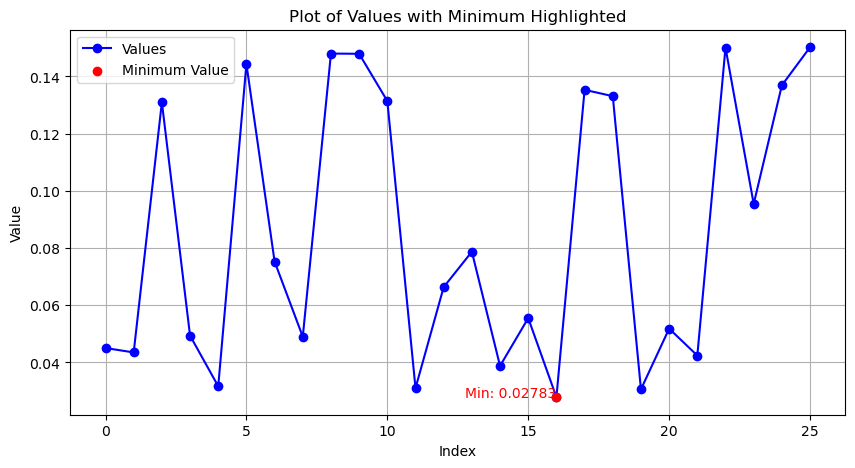

In [55]:
# Find the minimum value and its index
min_value = min(risk_list)
min_index = risk_list.index(min_value)

# Plot the values
plt.figure(figsize=(10, 5))
plt.plot(risk_list, marker='o', linestyle='-', color='b', label='Values')
plt.scatter(min_index, min_value, color='red', label='Minimum Value', zorder=5)
plt.text(min_index, min_value, f"Min: {min_value:.5f}", color='red', fontsize=10, ha='right')

# Add labels and legend
plt.title("Plot of Values with Minimum Highlighted")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

In [58]:
print("Optimal combination is: ")
all_combinations[min_index]

Optimal combination is: 


[0, 0.2, -0.1, -0.1, 0, 0, 0.1, -0.1, 0, 0.2, -0.1, -0.1]

In [59]:
# Initial beliefs
k = 101
D = np.array([1, 0, 0, 0, 0, 0])
delta = 0.1
warmup = True
states, observations = simulate(k, D, delta, warmup)

In [60]:
risk_list = []
for i in range(1, len(all_combinations)):
    states_list = []
    observations_list = []
    l = 1
    for t in range(1, 13):
        current_policy = all_combinations[i][t-1]
        delta = current_policy
        states_cont, observations_cont = simulate(l, D, delta, warmup)
        states_list.append(states_cont)
        observations_list.append(observations_cont)
    observations_list = np.vstack(observations_list)
    beliefs, v = update_beliefs(observations, D, B, A)
    Transition_matrix = []
    Transition_matrix.append(B)
    for t in range(1, 11):  # t from 1 to 10
        current_policy = policy_3[(t - 1) % len(policy_3)]
        delta = current_policy
        Transition_matrix.append(B)
    k = len(observations_list)
    beliefs_updated = np.zeros((k, len(D)))
    beliefs_updated[0] = beliefs[99]
    v_updated = np.zeros((k, len(D)))
    v_updated[0] = v[99]
    for t in range(1, 10):  # t from 0 to 9
        forward = np.dot(Transition_matrix[t-1], beliefs_updated[t-1] + 1e-8)
        backward = np.dot(Transition_matrix[t+1].T, beliefs_updated[t+1] + 1e-8)
        o_t = observations_list[t]
        observation_likelihood = np.dot(A, o_t)
        epsilon = 0.5 * (np.log(forward + 1e-8) + np.log(backward + 1e-8)) + np.log(observation_likelihood + 1e-8) - np.log(beliefs_updated[t] + 1e-8)
        v[t] = v[t] + epsilon
        beliefs_updated[t] = np.exp(v[t] - np.max(v[t]))
        beliefs_updated[t] /= beliefs_updated[t].sum()
    policy_belief = beliefs_updated[9]
    o_policy = np.dot(A.T, policy_belief)
    risk_policy = np.dot(o_policy, np.log(o_policy) - np.log(c2))
    risk_list.append(risk_policy)

print(risk_list)

[0.11619765502348098, 0.4515907472714218, 0.1353610930400237, 0.16249309780264704, 0.3617539346632021, 0.3977845738173464, 0.5635376634914383, 0.43476051167838203, 0.11120074771354044, 0.5045754815107995, 0.14259988543084745, 0.14302344108661955, 0.14205628742400117, 0.13430447853595046, 0.5489657384443036, 0.13207144693070202, 0.11873893169426245, 0.3550802408865765, 0.5143651933735687, 0.1402332419635497, 0.5108571482650569, 0.14199952363278429, 0.415499784313405, 0.16324972281297523, 0.36993076797523217, 0.3382970644477483]


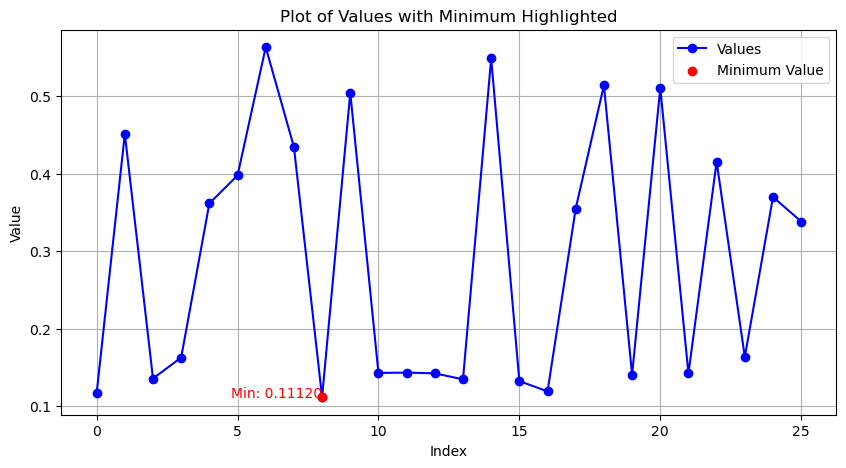

In [61]:
# Find the minimum value and its index
min_value = min(risk_list)
min_index = risk_list.index(min_value)

# Plot the values
plt.figure(figsize=(10, 5))
plt.plot(risk_list, marker='o', linestyle='-', color='b', label='Values')
plt.scatter(min_index, min_value, color='red', label='Minimum Value', zorder=5)
plt.text(min_index, min_value, f"Min: {min_value:.5f}", color='red', fontsize=10, ha='right')

# Add labels and legend
plt.title("Plot of Values with Minimum Highlighted")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

In [62]:
print("Optimal combination is: ")
all_combinations[min_index]

Optimal combination is: 


[0.2, 0, 0.1, -0.1, 0, 0, 0.1, -0.1, 0, 0, 0.1, -0.1]